# How to make a Slitherlink level generator

Slitherlink is a fun logic puzzle played on a grid; a good website to try it is [Krazydad](https://krazydad.com/play/slitherlink/), or if you have a tablet I would recommend the Slitherlink app by Conceptis.

![Example](images/003/slitherlink_example.png)

Above is an in-progress example of a Slitherlink puzzle.

It has the following rules:

*  If there is a number X in a cell, there must be exactly X filled-in edges around the number.
*  All the filled-in edges in a puzzle must join together to form a single continuous loop.

A good Slitherlink puzzle comes with the guarantee that there is a unique solution.  The above example has the solution:

![Solved Example](images/003/solved-slitherlink.png)

From the perspective of a Slitherlink generator, every puzzle has two components:

*  The solution
*  The hints

Given a solution, it is trivial to fill the grid with maximal hints - some process could be used to then remove hints iteratively to increase the difficulty of the puzzle, if desired.

Even without such a process we would still have a valid, if easy, Slitherlink puzzle; thus we should focus on generating a solution first.  Instead of trying to generate the loop itself, we can think of the loop as being the boundary between some shape and the outside of the grid.

As a first attempt, we will just generate a completely random 'shape'.  It will probably be disconnected and hence an invalid solution; this is just temporary to test the puzzle rendering.

```bash
conda install conda-forge::numpy=1.23.5
conda install conda-forge::matplotlib=3.6.2
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def random_slitherlink(
    shape: "Two element tuple"
) -> "0/1 numpy array with shape `shape`":
    return np.random.randint(0, 2, shape)
slither = random_slitherlink((7, 7))
slither

array([[1, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0]])

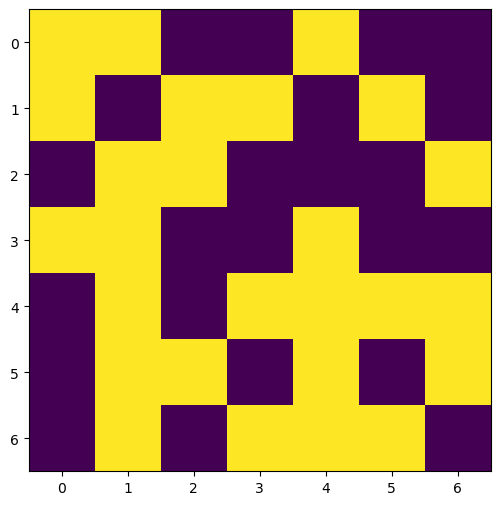

In [ ]:
def display_slitherlink_solution(
    grid: "0/1 numpy array"
) -> "(fig, ax) tuple for plotted figure":
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid)
    return (fig, ax)
display_slitherlink_solution(slither)
pass

Creating a good solution turns out to be a bit difficult, and I made some false starts.  Sam had the good idea of including false pathways in his blog as expandable dropdowns, which I will steal.  This way, people can still follow my thought process if desired, but false pathways do not distract from the flow of the true solution.

<details><summary style="color:red;">Attempt 1: Painting lines</summary>My first idea was to choose a random cell, and draw a straight line at a random distance from it.  Then, iteratively pick a random inside cell and create a new straight line (making sure to never intersect with an already created line).

I didn't quite finish the code for it (still some bugs - it's possible for it to cut the outside into multiple parts diagonally), but I abandoned the path because I wasn't happy with it - I had the idea for my next attempt, based on surface area, since I think it would be more elegant.

```python
def random_slitherlink(
    shape: "Two element tuple",
    iters: int = 5
) -> "Boolean numpy array with shape `shape`":
    # Initialize
    slither = np.zeros(shape).astype(bool)
    
    # Maybe transpose it
    transposed = np.random.randint(2)
    if transposed:
        slither = slither.T
    
    # Pick a random column to slither from
    slither[
        :np.random.randint(1, slither.shape[0]),
        np.random.randint(slither.shape[1])
    ] = True
    
    # Maybe flip it
    if np.random.randint(2):
        slither = slither[::-1]
    
    # Un-transpose it to preserve shape
    if transposed:
        slither = slither.T
    
    # Iteratively add slithers
    for i in range(iters):
        
        # Choose cell to expand
        choice = (
            np.random.choice(
                np.argwhere(slither.reshape(-1))[:, 0]
            )
        )
        row = choice // shape[1]
        col = choice % shape[1]
        
        # Always expand in the direction with the most space
        column_slithers = np.argwhere(slither[row]).reshape(-1) - col
        row_slithers = np.argwhere(slither[:, col]).reshape(-1) - row
        column_slithers = column_slithers[column_slithers != 0]
        row_slithers = row_slithers[row_slithers != 0]
        
        along_columns = True
        
        
        # Find the direction with the largest possible extension
        if len(row_slithers) == 0:
            row_slithers = np.array([0, shape[0]]) - row
        if len(column_slithers) == 0:
            column_slithers = np.array([0, shape[1]]) - col
        if np.abs(row_slithers).min() < np.abs(column_slithers).min():
            # More room to expand along columns
            along_columns = True
        else:
            along_columns = False
        
        # Flip the solution if along columns
        if along_columns:
            slither = slither.T
            row_slithers = column_slithers
            temp = row
            row = col
            col = temp
            
        # Left or right
        # Check if smallest-in-magnitude negative number
        # is larger than smallest-in-magnitude positive number
        # and if so, go left
        left = np.random.randint(0, 2) == 0
        if len(row_slithers) > 0:
            neg_sliths = -row_slithers[row_slithers <= 0]
            pos_sliths = row_slithers[row_slithers >= 0]
            
            if len(neg_sliths) > 0:
                max_left = neg_sliths.min()
            else:
                max_left = 0
                
            if len(pos_sliths) > 0:
                max_right = pos_sliths.min()
            else:
                max_right = 0
                
            if (max_left > max_right):
                left = True
            else:
                left = False
        else:
            if along_columns:
                slither = slither.T
            continue
                
        max_slither = max_left if left else max_right
        
        offset = np.random.randint(0, max_slither)
        if left:
            slither[row:row-offset, col] = True
        else:
            slither[row:row+offset, col] = True
            
        # Reset the flipped solution
        if along_columns:
            slither = slither.T
        
        
        
    
    return slither
display_slitherlink_solution(
    random_slitherlink((7, 10), iters=100)
)
pass
```
    
</details>

My next idea was based on circumference - large slitherlinks look very crumpled, and so intuitively they should have a large circumference compared to their area.  Imagine the following process:

*  Start with the entire grid enclosed in one loop
*  Pick a random cell to 'fold' inwards
   *  Only pick cells that can be folded without creating two loops
   *  Weight the random pick by cells that add the most edges
*  Stop when we reach a prespecificed circumference-to-area ratio

This should, hopefully, produce random crumpled loops.

To elaborate on "only pick cells that won't create two loops", there are two scenarios we need to avoid:
```
 |1|        |1|_
 |x|        |x 1
 |1|        |1|‾
```
In neither scenario can we fold in the x - in the first, it cuts the loop in two, and in the second, it results in four edges at a corner:
```
|1̲|_
 x̲|1̲
|1|
```

The procedure I've described is conceptually simple, but it took quite a lot of code to implement 😅 There're probably more elegant ways to program it


In [ ]:
def get_neighbors(ck, shape):
    neighbors = [
        (ck[0], ck[1]-1),
        (ck[0], ck[1]+1),
        (ck[0]-1, ck[1]),
        (ck[0]+1, ck[1])
    ]
    neighbors = [
        neighbor for neighbor in neighbors
        if neighbor[0] >= 0
        and neighbor[0] < shape[0]
        and neighbor[1] >= 0
        and neighbor[1] < shape[1]
    ]
    return neighbors

def get_neighbors_with_diags(ck, shape):
    neighbors = [
        (
            (ck[0]-1, ck[1]-1),
            (
                (ck[0], ck[1]-1),
                (ck[0]-1, ck[1])
            )
        ),
        (
            (ck[0]-1, ck[1]+1),
            (
                (ck[0], ck[1]+1),
                (ck[0]-1, ck[1])
            )
        ),
        (
            (ck[0]+1, ck[1]-1),
            (
                (ck[0], ck[1]-1),
                (ck[0]+1, ck[1])
            )
        ),
        (
            (ck[0]+1, ck[1]+1),
            (
                (ck[0], ck[1]+1),
                (ck[0]+1, ck[1])
            )
        )
    ]
    def valid(neigh, shape):
        return (
            neigh[0] >= 0
            and neigh[0] < shape[0]
            and neigh[1] >= 0
            and neigh[1] < shape[1]
        )
        
    neighbors = [
        (dia, (neigh1, neigh2)) for (dia, (neigh1, neigh2)) in neighbors
        if valid(neigh1, shape) and valid(neigh2, shape)
    ]
    return neighbors

def border_cell_is_valid(
    border_cell: ((int, int), int),
    solution: "0/1 numpy array with 1s being inside cells"
) -> bool:
    # Since as things change places that used to be border cells
    # are no longer border cells, we should return False if
    # it is no longer inside the loop
    cell = border_cell[0]
    shape = solution.shape
    if solution[cell] == 0:
        return False
    
    # Can't fold inwards if one of the new corners
    # borders an empty cell
    # I.e. can't be diagonally adjacent from an empty cell unless
    # there is an empty cell already between them.
    for dia, (neigh1, neigh2) in \
        get_neighbors_with_diags(cell, shape):
        
        if solution[dia] == 0:
            if solution[neigh1] == 1 and solution[neigh2] == 1:
                return False
            
    # Can't fold inwards if like:
    #
    #  0 1 0
    #  0 * 0
    #  0 1 0
    if cell[0]-1 < 0 or solution[cell[0]-1, cell[1]] == 0:
        # Above is a 0
        if cell[0]+1 >= shape[0] or solution[cell[0]+1, cell[1]] == 0:
            # Below is a zero
            return False
    if cell[1]-1 < 0 or solution[cell[0], cell[1]-1] == 0:
        # Left is a 0
        if cell[1]+1 >= shape[1] or solution[cell[0], cell[1]+1] == 0:
            # Right is a zero
            return False
    
    # Can't be valid to remove if it has no inside adjacents
    # This shouldn't trigger except in trivial cases
    if border_cell[1] == 0:
        return False
    return True

Out of valid cells to remove


(<Figure size 600x600 with 1 Axes>, <AxesSubplot: >)

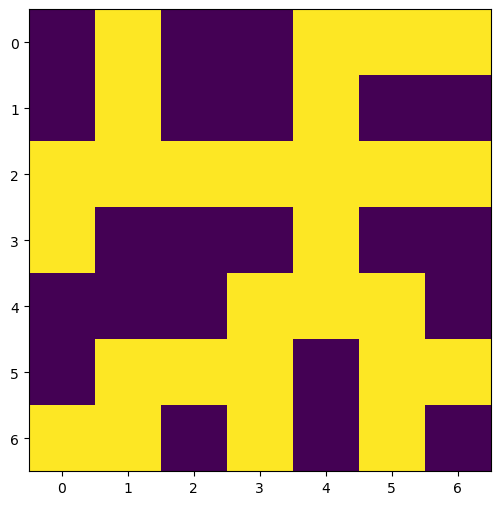

In [ ]:
def random_slitherlink(
    shape: ("height", "width"),
    target_ratio: float = 2
) -> "0/1 numpy array with shape `shape`":
    
    # Initialize to full loop
    solution = np.ones(shape)
    
    # Get all cells bordering
    border_cells: (dict, "(x, y): # outside cells it borders")
    border_cells = set(
        [(0, j) for j in range(shape[1])]
        + [(shape[0]-1, j) for j in range(shape[1])]
        + [(i, 0) for i in range(shape[0])]
        + [(i, shape[1]-1) for i in range(shape[0])]
    )
    border_cells = {
        cell: 3
        for cell in border_cells
    }
    border_cells[(0, 0)] = 2
    border_cells[(shape[0]-1, 0)] = 2
    border_cells[(0, shape[1]-1)] = 2
    border_cells[(shape[0]-1, shape[1]-1)] = 2
    total_weight = sum(border_cells.values())
    
    # Initialize circ-area ratio
    circumference = 2 * (shape[0] + shape[1])
    area = shape[0] * shape[1]
    circ_area_ratio = circumference / area
    
    while circ_area_ratio < target_ratio:
        # Pick a random border_cell, by weight
        border_cells_by_weight = {
            key: value
            for key, value in border_cells.items()
            if border_cell_is_valid((key, value), solution)
        }
        total_weight = sum(border_cells_by_weight.values())
        border_cells_by_weight = {
            key: value / total_weight
            for key, value in border_cells_by_weight.items()
        }
        if len(border_cells_by_weight) == 0:
            print("Out of valid cells to remove")
            break
        rando = np.random.random()
        chosen_key: "The cell to fold in on itself" = None
        for key, value in border_cells_by_weight.items():
            rando -= value
            if rando <= 0:
                chosen_key = key
                break
                
        if chosen_key is None:
            raise Exception("No key chosen")
        
        if solution[chosen_key] == 0:
            raise Exception("Cell removed twice")
        solution[chosen_key] = 0
        inner_neighbors = border_cells[chosen_key]
        
        # Update neighbors
        neighbors = get_neighbors(chosen_key, shape)
        
        # Every adjacent cell should loose 1 from its value
        for neighbor in neighbors:
            if neighbor not in border_cells:
                neigh_neighbors = get_neighbors(neighbor, shape)
                border_cells[neighbor] = sum(
                    solution[neigh_neighbor]
                    for neigh_neighbor in neigh_neighbors
                )
            else:
                border_cells[neighbor] -= 1
        
        # Update values for the next loop
        circumference += inner_neighbors
        area -= 1
        circ_area_ratio = circumference / area
    
    return solution

display_slitherlink_solution(
    slitherlink := random_slitherlink(
        (7, 7),
        target_ratio = 3.5
    )
)

And it seems to have worked quite well!  Now we just need the clues.  Calculating the amount of adjacent cells is like a convolution (as in a layer from a CNN).  To keep the environment minimal, I won't import anything beyond NumPy; I'll just code it myself.

In [ ]:
def get_clues_from_solution(solution):
    right = np.pad(solution[:, 1:], ((0, 0), (0, 1)), constant_values=0)
    left = np.pad(solution[:, :-1], ((0, 0), (1, 0)), constant_values=0)
    down = np.pad(solution[1:, :], ((0, 1), (0, 0)), constant_values=0)
    up = np.pad(solution[:-1, :], ((1, 0), (0, 0)), constant_values=0)
    clues = (left + right + up + down)
    
    # For outside cells, borders are other way round
    clues[solution == 1] = 4 - clues[solution == 1]
    return clues

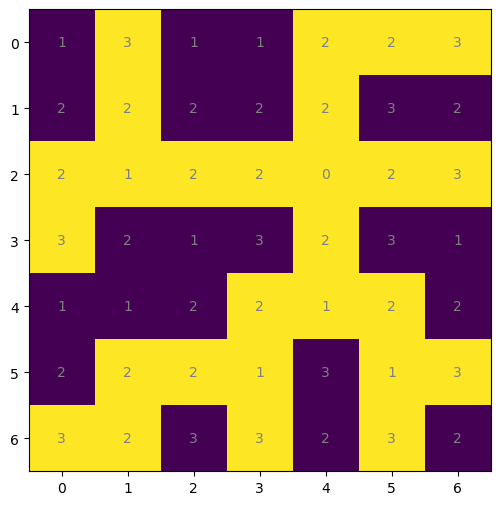

In [ ]:
def display_slitherlink_clues(
    solution: "0/1 numpy array"
) -> "(fig, ax) tuple for plotted figure":
    fig, ax = plt.subplots(figsize=(6, 6))
    shape = solution.shape
    grid = get_clues_from_solution(solution)
    ax.imshow(solution)
    for i in range(shape[0]):
        for j in range(shape[1]):
            text = ax.text(j, i, int(grid[i, j]),
                ha="center", va="center", color="gray")
    return (fig, ax)
display_slitherlink_clues(slitherlink)
pass